In [29]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import torch
import sys,os
sys.path.append(os.getcwd())

from b724_c1.network import Network

In [30]:
v_0 = 10e-6     # Loading velocity [m/s]
k = 14.8*1e9    # Spring stiffness [Pa/m]
beta_1 = 1.2    # b₁/a₀ [non-dim]
L_1 = 3*1e-6    # Critical distance for θ₁ [m]
rho = 0.1
L_2 = rho*L_1

a = 0.01        # Friction direct effect [non-dim]
mu_0 = 0.64       # Static friction coefficient [non-dim]
lam = a/mu_0

G = 31e9         # Rigidity modulus of quartz [Pa]
rho_v = 2.65e3   # Density of quartz [kg/m^3]
c_s = np.sqrt(G/rho_v)
eta_0 = G/(2*c_s)
eta = 1*eta_0

p_0 = 1.01325e5  # Reference surrounding pressure (atmospheric pressure) [Pa]

beta_a = 1e-9    #[0.5-4]*1e-9 (David et al., 1994; see Segall and Rice, 1995)
beta_m = 1e-11       # Compressibility of Quartz (Pimienta et al., 2017, JGR, fig. 12)
phi_0 = 0.075       # Reference porosity
beta = phi_0*(beta_a+beta_m)
epsilon = -0.017*1e-3  # Dilatancy/Compressibility coefficient
#
c_0 = 10          # Diffusivity [1/s]
gamma = c_0*L_1/v_0
sigma_n0 = 13.600*1e6

In [31]:
c=np.array([0.0] * 2)
exp_names=[''] * 2
c[0]  = 1; exp_names[0]  = "b724_c1"
# sigma_n0[1]  = 14.000*1e6; exp_names[1]  = "b722"
c[1]  = 0.1; exp_names[1]  = "b724_c0.1"
# # sigma_n0[2]  = 15.001*1e6; exp_names[2]  = "b726"
# sigma_n0[2]  = 15.400*1e6; exp_names[2]  = "b694"
# sigma_n0[3]  = 16.389*1e6; exp_names[3]  = "b697"
# # sigma_n0[5]  = 17.003*1e6; exp_names[5]  = "b693"
# sigma_n0[4]  = 17.379*1e6; exp_names[4]  = "b698"
# # sigma_n0[7]  = 17.909*1e6; exp_names[7]  = "b695"
# sigma_n0[5] = 20.002*1e6; exp_names[5] = "b728"
# sigma_n0[6] = 21.985*1e6; exp_names[6] = "b721"
#sigma_n0[11] = 23.012*1e6; exp_names[11] = "b725"

# sigma_n0 = 17.003*1e6

# 简化参数
tau_0 = mu_0*sigma_n0  # (10)
kappa = (k*L_1) / (a*sigma_n0) #26(a)
nu = eta*v_0 / (a*sigma_n0) #26(b)
rho = rho
beta_2 = -epsilon/(lam*beta*sigma_n0) #26(d)
alpha = (c_0*p_0*L_1) / (v_0*lam*sigma_n0)  #26(e)
gamma = gamma

In [32]:
def predict(exp_name):
    device = torch.device(
        "cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = Network(
        input_size=1,
        hidden_size=200,
        output_size=4,
        depth=4,
        act=torch.nn.Tanh
    ).to(device)

    model_path = '{}/model.pth'.format(exp_name)
    # 从文件加载状态字典
    state_dict = torch.load(model_path, map_location=device)

    # 将状态字典加载到模型
    model.load_state_dict(state_dict)

    # 设置模型为evaluation状态
    model.eval()

    # 生成时空网格
    deta_t = 0.1
    t = torch.arange(0, 6, deta_t)
    t1 = torch.arange(0, 6, 0.1)
    X = t.reshape(1, -1).T
    X = X.to(device)

    # 计算该时空网格对应的预测值
    with torch.no_grad():
        U_pred = model(X).cpu().numpy()

    data = np.loadtxt('{}/data1.txt'.format(exp_name))

    return U_pred,data

In [33]:
pred_all = []
data_all = []
for exp_name in exp_names:
    pred, data  = predict(exp_name)
    pred_all.append(pred)
    data_all.append(data)

/var/folders/tn/p5ymmz5s4wjgv5vg98_14t0w0000gn/T/ipykernel_9872/528685876.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_locati

In [34]:
# 生成时空网格
deta_t = 0.1
t = torch.arange(0, 6, deta_t)
t_real = t*L_1/v_0

In [35]:
def plot_setting(ax):
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')
    # ax.set_xlim(0, 15)
    ax.tick_params(axis='both', direction='out', length=6, width=1.5)
    ax.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

In [64]:
# 设置全局字体和大小
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial（你也可以选择其他字体）
plt.rcParams['font.size'] = 15

def plot_subplot(t_real, data, pred, i, index, v_0, a, sigma_n0, tau_0):
    ax = plt.subplot(2, 2, i)
    ax.plot(t_real, np.exp(data[index][:, 0]) * v_0 * 1e6, c='black', linewidth=2, alpha=0.5)
    ax.scatter(t_real, np.exp(pred[index][:, 0]) * v_0 * 1e6, c='red', edgecolor='grey')
    ax.text(0.98, 0.9, r'$c_*$= {}'.format(c[index]), ha='right', va='top', transform=ax.transAxes, fontsize=14)
    if index<5:ax.text(0.01, 0.9, r'$\sigma_{n0}$'+' = {:.2f} MPa'.format(sigma_n0*1e-6), ha='left', va='top', transform=ax.transAxes, fontsize=12)
    # else:ax.text(0.01, 0.5, r'$\sigma_{n0}$'+' = {:.2f} MPa'.format(sigma_n0*1e-6), ha='left', va='top', transform=ax.transAxes, fontsize=12)
    # ax.set_ylabel(r'v (1e-6 m/s)')
    plot_setting(ax)
    if index==1: ax.set_title(r'v (1e-6 m/s)',size=15)
    if index==0:
        ax.set_xlabel('Time (s)',size=15)
        ax.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)


    ax = plt.subplot(2, 2, i+1)
    ax.plot(t_real, (data[index][:, 1] * a * sigma_n0 + tau_0) * 1e-6, c='black', linewidth=2, alpha=0.5)
    ax.scatter(t_real, (pred[index][:, 1] * a * sigma_n0 + tau_0) * 1e-6, c='red', edgecolor='grey')
    ax.text(0.98, 0.9,  r'$c_*$= {}'.format(c[index]), ha='right', va='top', transform=ax.transAxes, fontsize=14)
    # ax.set_ylabel(r'$\tau_f$ (Mpa)')
    plot_setting(ax)
    if index==1: ax.set_title(r'$\tau_f$ (Mpa)',size=15)
    if index==0:
        ax.set_xlabel('Time (s)',size=15)
        ax.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)

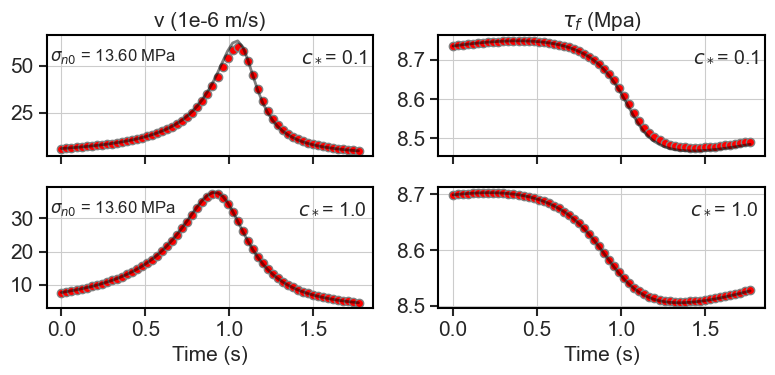

In [65]:
plt.figure(figsize=(8, 4))

# 生成子图
index=1 #数据索引
for i in range(1,4,2):
    # print(exp_names[i])
    plot_subplot(t_real, data_all, pred_all, i,index, v_0, a, sigma_n0, tau_0)
    index=index-1

plt.subplots_adjust(hspace=0.3,wspace=0.35)
plt.tight_layout()
plt.savefig('../plot/figure/forward_diff_c.pdf',dpi=300)

In [48]:
#计算预测和数据的速度和剪应力
vel_pred_all=[]
tau_pred_all=[]
for i in range(2):
    vel_pred = np.exp(pred_all[i][:,0])* v_0 *1e6
    ShearStress_pred = (pred_all[i][:,1]*a*sigma_n0+tau_0)*1e-6
    vel_pred_all.append(vel_pred)
    tau_pred_all.append(ShearStress_pred)

vel_data_all=[]
tau_data_all=[]
for i in range(2):
    vel_data = np.exp(data_all[i][:,0])* v_0 *1e6
    ShearStress_data = (data_all[i][:,1]*a*sigma_n0+tau_0)*1e-6
    vel_data_all.append(vel_data)
    tau_data_all.append(ShearStress_data)

In [49]:
#计算预测和数据的差异 rae
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
nmses_vel,nmses_tau=[],[]
pccs_vel,pccs_tau=[],[]
for i in range(2):
    mse = mean_squared_error(vel_data_all[i], vel_pred_all[i])
    nmse = mse / np.var(vel_data_all[i])
    correlation, _ = pearsonr(vel_data_all[i], vel_pred_all[i])
    nmses_vel.append(nmse)
    pccs_vel.append(correlation)

    mse = mean_squared_error(tau_data_all[i], tau_pred_all[i])
    nmse = mse / np.var(tau_data_all[i])
    correlation, _ = pearsonr(tau_data_all[i], tau_pred_all[i])
    nmses_tau.append(nmse)
    pccs_tau.append(correlation)

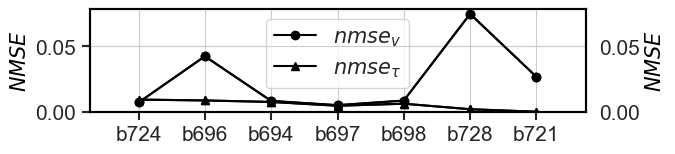

In [95]:
fig, ax1 = plt.subplots(figsize=(7, 1.8))
ax1.bar(exp_names, sigma_n0 * 0)
ax1.plot(exp_names,nmses_vel,'-o',c='black',label=r'$nmse_v$')
ax1.plot(exp_names,nmses_tau,'-^',c='black',label=r'$nmse_{\tau}$')
plot_setting(ax1)
ax1.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)
ax1.set_ylabel(r'$NMSE$', color='black')
ax1.legend()

ax2 = ax1.twinx()
ax2.bar(exp_names, sigma_n0 * 0)
ax2.set_ylabel(' ')
ax2.plot(exp_names,nmses_vel,'-o',c='black',label=r'$nmse_v$')
ax2.plot(exp_names,nmses_tau,'-^',c='black',label=r'$nmse_{\tau}$')
ax2.set_ylabel(r'$NMSE$', color='black')
plot_setting(ax2)

plt.tight_layout()
plt.savefig('../plot/figure/forward_diff_sigma_3.pdf',dpi=300)

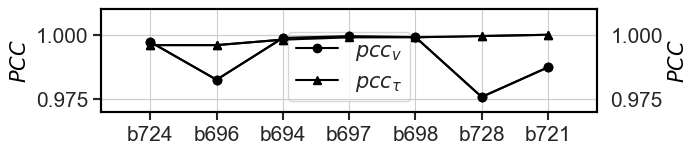

In [103]:
fig, ax1 = plt.subplots(figsize=(7, 1.8))
ax1.bar(exp_names, sigma_n0 * 0)
ax1.plot(exp_names,pccs_vel,'-o',c='black',label=r'$pcc_v$')
ax1.plot(exp_names,pccs_tau,'-^',c='black',label=r'$pcc_{\tau}$')
plot_setting(ax1)
ax1.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)
ax1.set_ylabel(r'$PCC$', color='black')
ax1.legend()
ax1.set_ylim(0.97,1.01)

ax2 = ax1.twinx()
ax2.bar(exp_names, sigma_n0 * 0)
ax2.set_ylabel(' ')
ax2.plot(exp_names,pccs_vel,'-o',c='black',label=r'$pcc_v$')
ax2.plot(exp_names,pccs_tau,'-^',c='black',label=r'$pcc_{\tau}$')
ax2.set_ylabel(r'$PCC$', color='black')
plot_setting(ax2)
ax2.set_ylim(0.97,1.01)
plt.tight_layout()
plt.savefig('../plot/figure/forward_diff_sigma_4.pdf',dpi=300)

In [104]:
#计算不同时间点的差异
def min_max_normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

vels_diftime,taus_diftime=[],[]
for i in range(7):
    vel_diftime = vel_data_all[i]-vel_pred_all[i]
    vel_diftime_normalized = min_max_normalize(vel_diftime)
    tau_diftime= tau_data_all[i]-tau_pred_all[i]
    tau_diftime_normalized = min_max_normalize(tau_diftime)
    vels_diftime.append(vel_diftime_normalized)
    taus_diftime.append(tau_diftime_normalized)

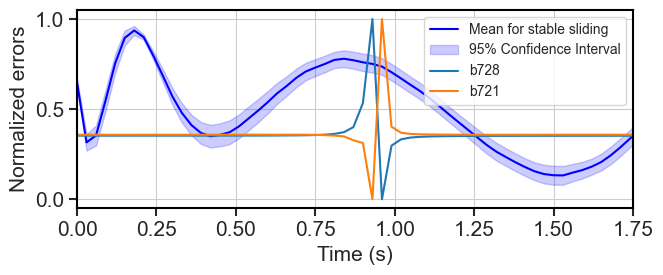

In [141]:
mean_values = np.mean(vels_diftime[:5], axis=0)  # 沿轴 1 计算均值
std_values = np.std(vels_diftime[:5], axis=0)    # 沿轴 1 计算标准差

# 计算标准误和 95% 置信区间
n = 60  # 样本数（前 5 行）
se_values_1 = std_values / np.sqrt(n)  # 标准误
confidence_interval_1 = 1.96 * se_values_1  #

# 绘制图表
fig, ax = plt.subplots(figsize=(7,3))
plt.plot(t_real, mean_values, 'b-', label='Mean for stable sliding')
plt.fill_between(t_real, mean_values - confidence_interval_1, mean_values + confidence_interval_1, color='b', alpha=0.2, label='95% Confidence Interval')
plt.plot(t_real,vels_diftime[5],label='b728')
plt.plot(t_real,vels_diftime[6],label='b721')
plt.xlabel('Time (s)')
plt.ylabel('Normalized errors')
plt.legend(fontsize=10)
plt.grid(True)
plot_setting(ax)
plt.xlim(0,1.75)
ax.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)
plt.tight_layout()
plt.savefig('../plot/figure/forward_diff_sigma_5.pdf',dpi=300)

In [ ]:
#不同正应力的解算误差
#不同时间的解算误差
#不同事件的解算误差。